# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## План проекта
**1. Проведение обзора данных**

**Первичное исследование данных:** 
* Импорт необходимых библиотек
* Чтение файлов и сохранение полученных данных в переменные
* Получение общей информации о таблицах (head, info, describe)
* Выводы

**Исследование задачи:** 
* Графическое представление данных из таблиц
* Исследование зависимостей между данными
* Выводы

**2. Обучение и проверка модели:**
* Разбивка данных на выборки
* Маштабирование количественных признаков
* Моделирование 
* Анализ качества модели
* Выводы

**3. Подготовка к расчёту прибыли:**
* Расчет минимальных запасов в регионе
* Выводы

**4. Расчёт прибыли и рисков:**
* Расчет прогнозной прибыли
* Расчет рисков
* Выводы

**5. Общий вывод**

## Загрузка и подготовка данных

### Загрузка данных

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import math
import numpy as np
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')
from statistics import mean

In [2]:
RANDOM_STATE = 12345

In [3]:
# Напишем функцию для первичной проверки данных
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)
    
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T) 
    
    
    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')    
    df_object = data_df.select_dtypes(include='object').columns
    
    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())

In [4]:
def plot_hist(data, col_column, label=''):
    '''
    Функция отрисовки гистограмм и ящика с усами для количесвтенных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = len(col_column)
    f, ax = plt.subplots(rows,2, figsize=(8, 15))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(14)
    plt.rcParams.update({'font.size': 18})
    
    for i, col in enumerate(col_column):         
        sns.histplot(data[col], kde=True, bins=24, ax = ax[i, 0])                    
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    title = "Гистограмма и ящик с усами для количественных данных" + label
    plt.suptitle(title, fontsize=22, y=1.01)
    plt.show()

In [5]:
def quality_model(fact, prediction):
    '''
    Функция анализа качества модели:
    - R2 для регрессионных моделей.
    - Графики остатков: гистограмма, скатерплот "остатки - предсказанные значения"
    '''
    params = {'axes.labelsize' : 14, 'figure.titlesize': 18,
              'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize' :12
             }
    plt.rcParams.update(params)    
    
    fact = pd.DataFrame(fact.reset_index(drop = True))
    pred = pd.DataFrame(prediction.flatten(), columns = ['предсказанное'])
    df = pd.concat([fact, pred], axis = 1)

    print('\033[1m'+'РАСЧЁТ R2:'+ '\033[0m')
    print('\033[1m'+'Учтённые факторы на', round(r2_score(df['product'],df['предсказанное']),2)*100, 'процентов объясняют целевую'+ '\033[0m')        
        
    fig, ax = plt.subplots(1, 2, figsize = (9,3))
    plt.tight_layout()
    plt.suptitle('Анализ остатков модели', y=1.05)
    
    sns.scatterplot(data = df, x = 'предсказанное',  y = df['product'] - df['предсказанное'], ax = ax[0])
    sns.histplot(x = df['product'] - df['предсказанное'], bins = 80, kde=True, ax = ax[1])
    
    ax[1].axvline(x=(df['product'] - df['предсказанное']).mean(), color='r', label='mean')
    ax[1].axvline(x=(df['product'] - df['предсказанное']).median(), color='tab:orange', label='median')
    
    ax[0].set_xlabel('Предсказанные значения')
    ax[1].set_ylabel('')
    ax[1].legend()
    plt.show()

In [6]:
def metrics_model(fact, prediction, fact_best, prediction_beat):
    '''
    Функция расчёта точности модели
    выводит метрики качества для регрессионных моделей (точность модели).
    '''
       
    print('R2   = ', round(r2_score(fact, prediction),2))
    print('MAPE = ', round(mean_absolute_percentage_error(fact, prediction)*100,2), 'процентов')
    print('MAE  = ', round(mean_absolute_error(fact, prediction),2))
    print('RMSE = ', round(mean_squared_error(fact, prediction)**0.5,2))
    print('Запас предсказанного сырья (200 лучших скважин) = ', round(prediction_beat.sum(),2))
    print('Запас реального сырья (200 лучших скважин) = ', round(fact_best.sum(),2))

In [7]:
# Считываем данные из csv-файлов в датафреймы и сохраняем в переменных geo_data_0, geo_data_1, geo_data_2
try:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')   

In [8]:
# Записываем данные в массив, чтобы выполнять построение графиков, анализ данных в циклах

data = []
data.append(geo_data_0)
data.append(geo_data_1)
data.append(geo_data_2)

In [9]:
for num, geo_data in enumerate(data):
  print('Данные по геологоразведке по региону', num)
  display(geo_data)

Данные по геологоразведке по региону 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


Данные по геологоразведке по региону 1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


Данные по геологоразведке по региону 2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


Загруженные таблицы соответствует заданию.

Признаки:
<li>id — уникальный идентификатор скважины;</li>
<li>f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);</li>

Целевой признак:
 <li>product — объём запасов в скважине (тыс. баррелей).</li>

### Первичный осмотр данных

In [10]:
for num, geo_data in enumerate(data):
  print('Описание данных по региону ' + str(num))
  print()
  check_data(geo_data)

Описание данных по региону 0

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347



Описание категориальных данных:


,count,unique,top,freq
id,100000,99990,HZww2,2



Вывод уникальных значений по каждому категориаьному признаку:
_id


HZww2    2
fiKDv    2
A5aEY    2
bsk9y    2
bxg6G    2
        ..
IBi7e    1
2efec    1
zP0sT    1
PKsHL    1
QkVnj    1
Name: id, Length: 99990, dtype: int64

Описание данных по региону 1

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408



Описание категориальных данных:


,count,unique,top,freq
id,100000,99996,LHZR0,2



Вывод уникальных значений по каждому категориаьному признаку:
_id


LHZR0    2
bfPNe    2
5ltQ6    2
wt4Uk    2
UnKIB    1
        ..
UoCPb    1
yCGg3    1
O5Nby    1
TG1nO    1
fsQxd    1
Name: id, Length: 99996, dtype: int64

Описание данных по региону 2

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838



Описание категориальных данных:


,count,unique,top,freq
id,100000,99996,Vcm5J,2



Вывод уникальных значений по каждому категориаьному признаку:
_id


Vcm5J    2
VF7Jo    2
xCHr8    2
KUPhW    2
1iK2S    1
        ..
yvapt    1
yuDCr    1
XKX6Q    1
gvYHe    1
oAVTl    1
Name: id, Length: 99996, dtype: int64

Вывод: Исходя из полученных графиков и информации о датасете видно что датасет предобработан: в нем нету пропущенных значений, дубдикатов и некорректных значений. Можно приступать к исследованию. 

 ## Исследование задачи


### Графичечкий анализ данных

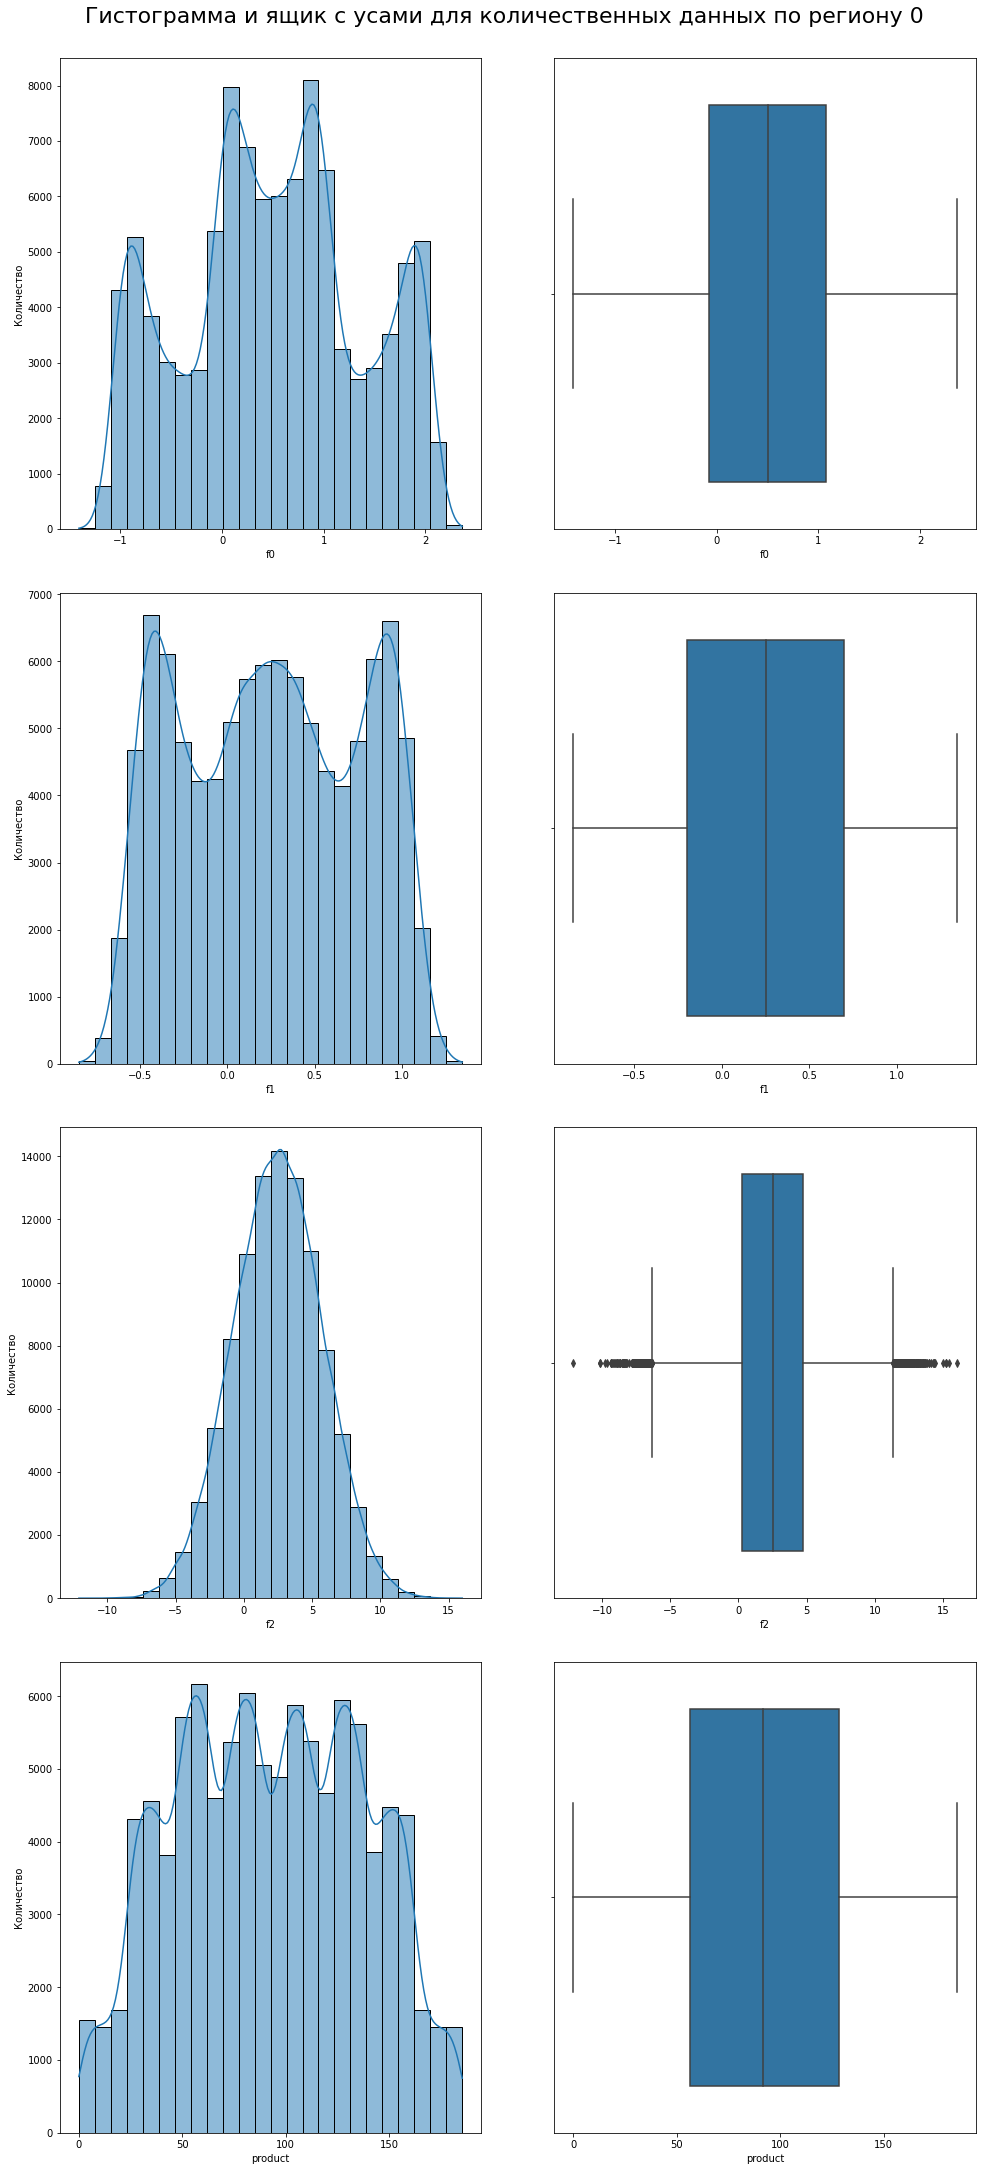

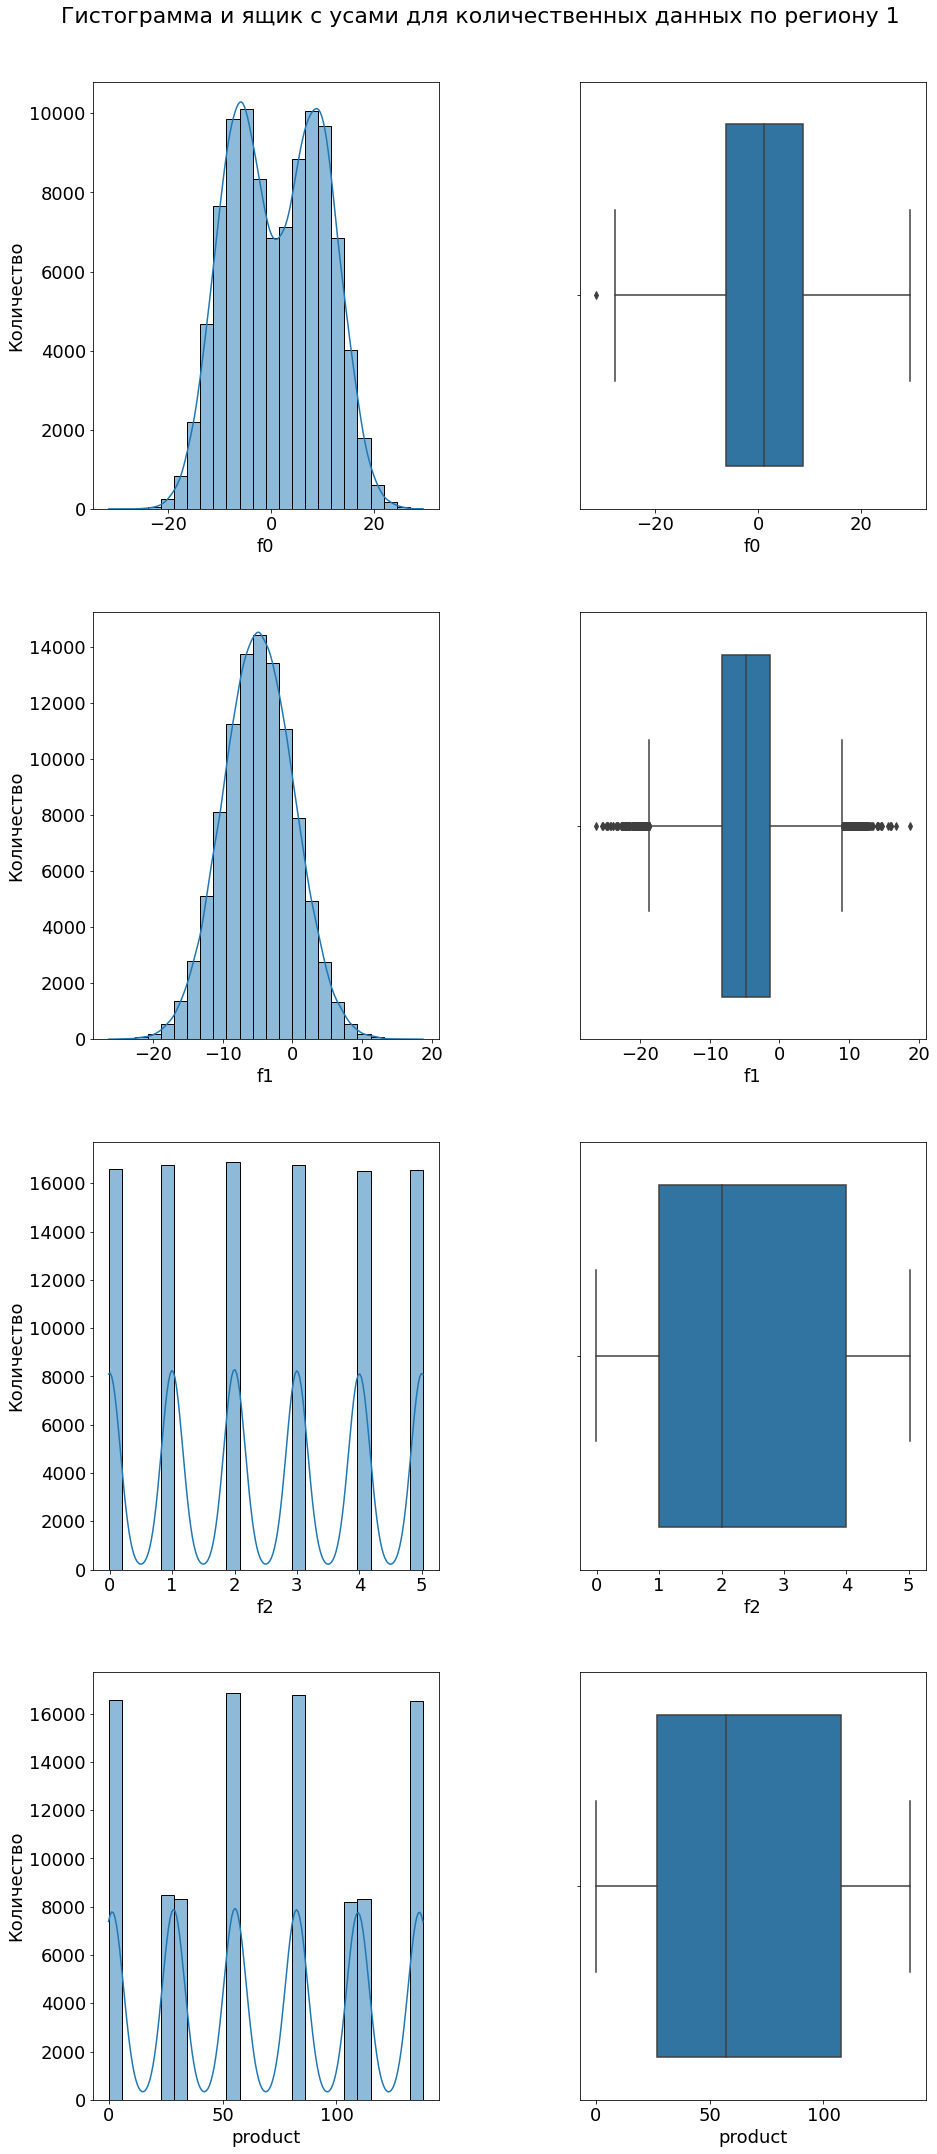

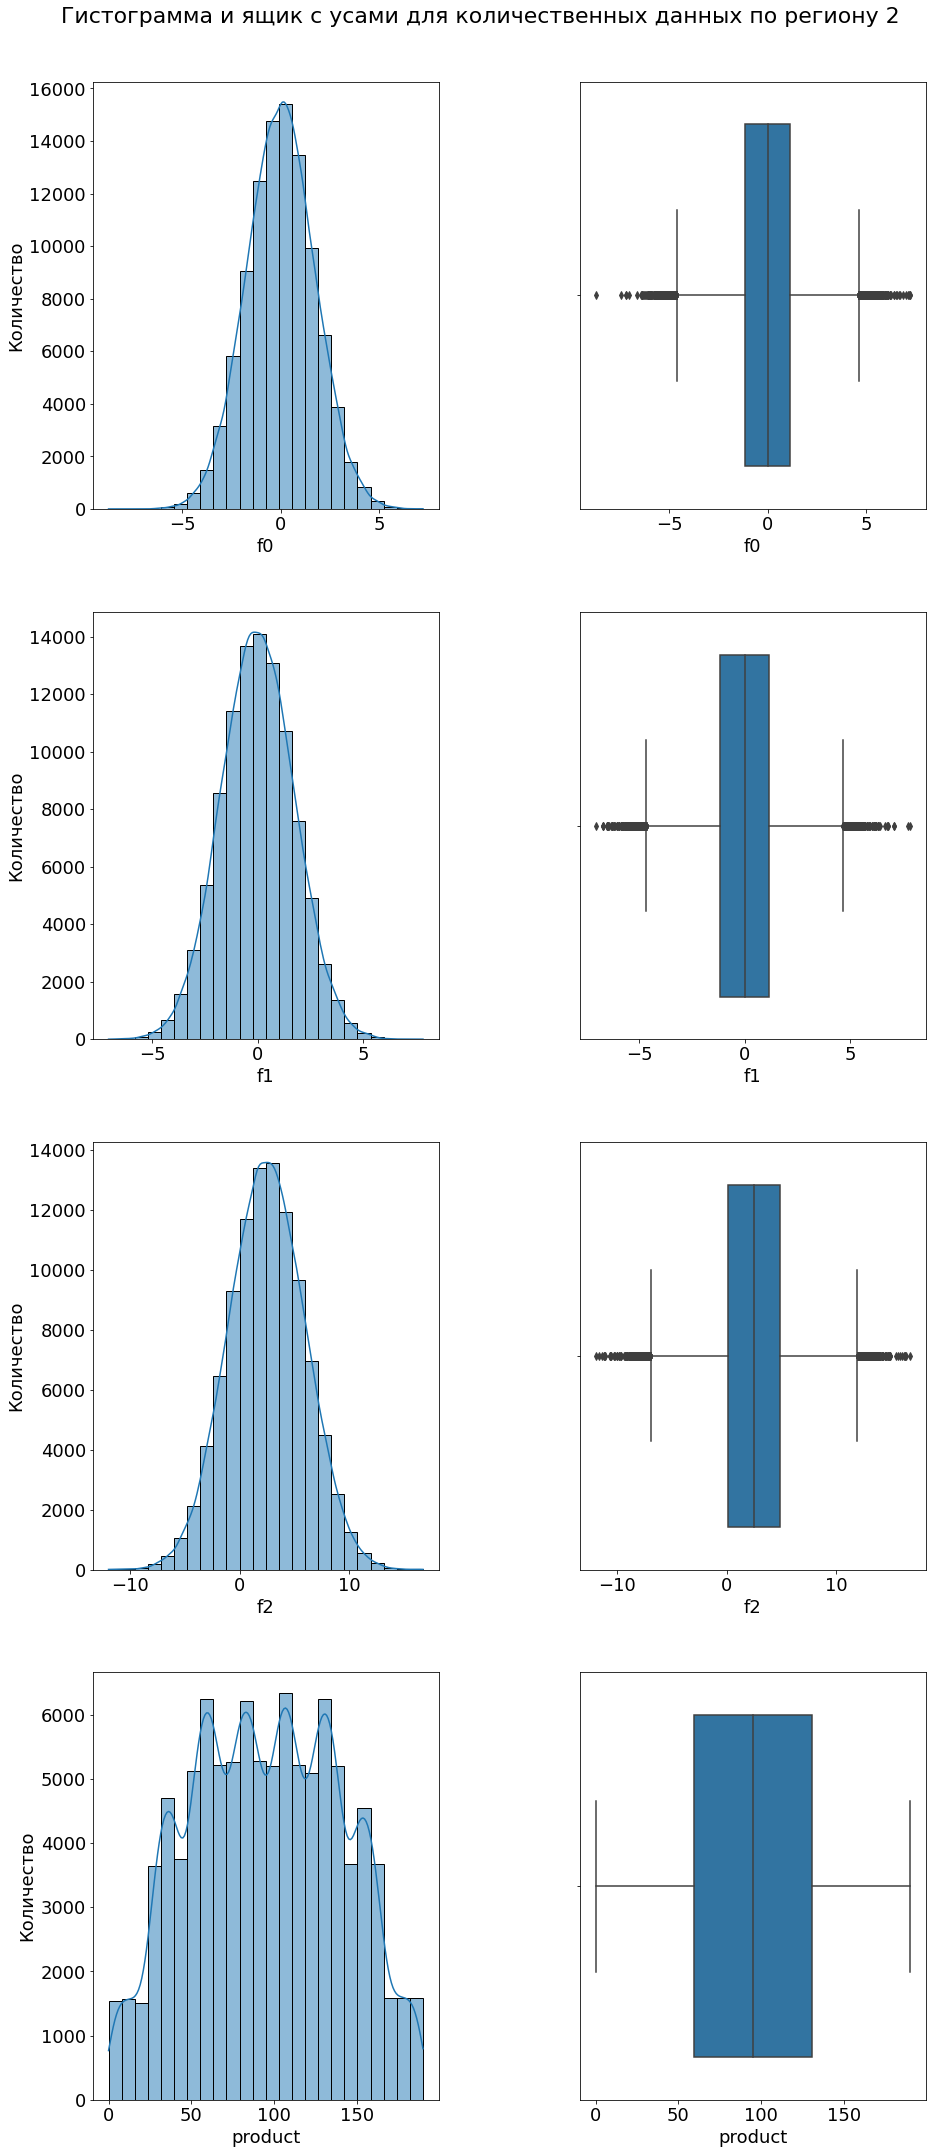

In [11]:
# ГРАФИЧЕСКИЙ АНАЛИЗ количественных данных данных
for num, geo_data in enumerate(data): 
  num_features = ['f0', 'f1', 'f2', 'product']
  plot_hist(geo_data, num_features, ' по региону ' + str(num))

Как видим из графиков данные распределены в основном, не нормально. Нормально распределнными являются данные по признаку f2 для региона 0, данные по признаку f1 для региона 1, данные по признакам f0, f1, f2 для региона 2.

### Корреляционный анализ данных

Так как по условию задачи мы будем использовать регрессионную модель, для которой важно наличние линейной связи между факторами и целевым признаком, оценим зависимости между данными. Для этого построим график скатерплот между объёмом запасов в скважине и остальными факторами.

In [12]:
num_features = ['f0', 'f1', 'f2']

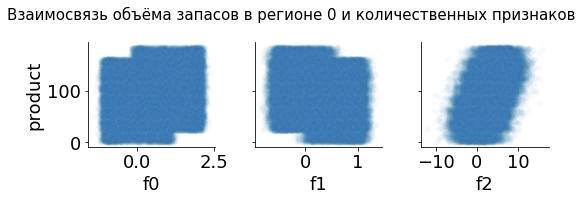

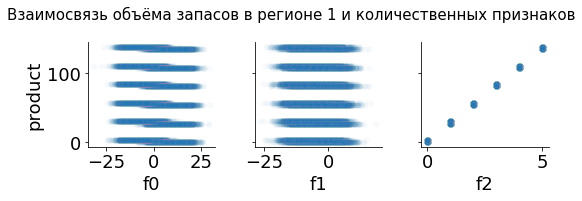

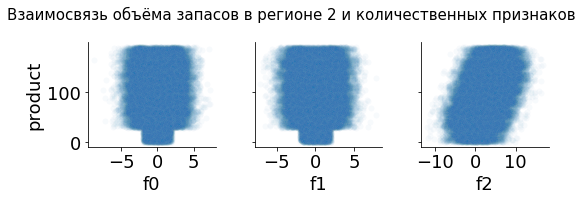

In [13]:
for num, geo_data in enumerate(data): 
  g = sns.PairGrid(geo_data, x_vars=num_features, y_vars=geo_data['product'].name)
  title = "Взаимосвязь объёма запасов в регионе " + str(num) + " и количественных признаков"
  g.fig.suptitle(title, y=1.1, fontsize=15)
  g.map_diag(sns.histplot, color=".3")
  g.map_offdiag(sns.scatterplot, alpha=0.03)
  g.add_legend()
  plt.show()

Как видно из графиков для 1 региоа между признаками есть явная зависимость у признака f2. Для региона 0 и 2 она только слегка выражена.

Проведем рассчет числовых значений корреляции

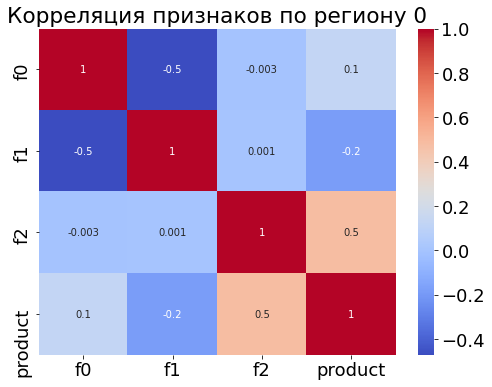

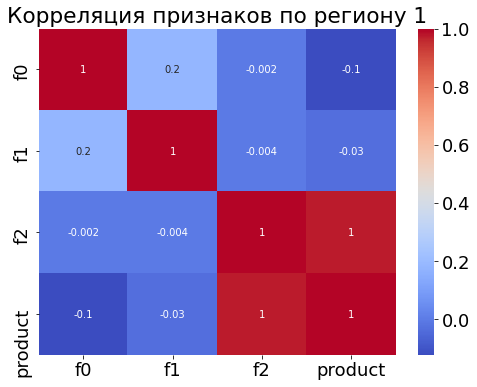

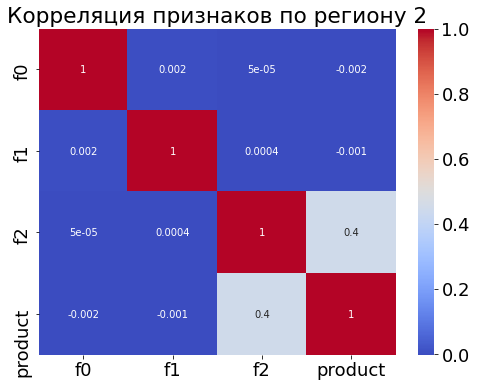

In [14]:
# (Т.к. есть ненормальность в некоторых данных- выберем метод СПИРМЕНА. Используем график тепловых карт)
for num, geo_data in enumerate(data): 
  plt.close()
  plt.figure(figsize=(8, 6))
  title = 'Корреляция признаков по региону ' + str(num)
  plt.title(title)
  sns.heatmap(geo_data.corr(method='spearman'), annot = True, cmap="coolwarm", annot_kws={'size':10}, fmt='.1g')
  plt.show()

**Вывод: Для 1 региона объём запасов в скважине зависит от параметра f2. Корреляция между ними равна 1. Для регионов 0, 2 эта зависимость не так выражена (корреляция равна 0.5 и 0.4 соответственно). Между факторами нет высокой корреляции (более 0.9). Т.е мультиколлинеарности не наблюдается.**


## Обучение и проверка модели

### Подготовка выборок

In [15]:
# Создадим датасеты с признакими, исключив из исходного датасета целевой признак и ненужные столбцы - id, region
# которые не влияют на объём запасов в скважине
features_list = []
target_list = []

for geo_data in data:  
  features = geo_data.drop(['product', 'id'], axis=1)
  features_list.append(features)
  # Создадим датасет с целевым признаком
  target = geo_data['product']
  target_list.append(target)

In [16]:
# Разобьём на тренировочную выборку и тестовую
features_train_list = []
features_test_list = []
target_train_list = []
target_test_list = []

for i in range(len(features_list)):
  features_train, features_test, target_train, target_test = train_test_split(
      features_list[i], target_list[i], test_size=0.25, random_state=RANDOM_STATE)
  features_train_list.append(features_train)
  features_test_list.append(features_test)
  target_train_list.append(target_train)
  target_test_list.append(target_test)

In [17]:
# Проверка
for i in range(len(features_train_list)):
  print('Выборки по региону ' + str(i))
  print('Размер обучающей выборки (признаки) -', features_train_list[i].shape[0])
  print('Размер обучающей выборки (целевой признак) -', target_train_list[i].shape[0])
  print('Размер тестовой выборки (признаки) -', features_test_list[i].shape[0])
  print('Размер тестовой выборки (целевой признак) -', target_test_list[i].shape[0])
  print()

Выборки по региону 0
Размер обучающей выборки (признаки) - 75000
Размер обучающей выборки (целевой признак) - 75000
Размер тестовой выборки (признаки) - 25000
Размер тестовой выборки (целевой признак) - 25000

Выборки по региону 1
Размер обучающей выборки (признаки) - 75000
Размер обучающей выборки (целевой признак) - 75000
Размер тестовой выборки (признаки) - 25000
Размер тестовой выборки (целевой признак) - 25000

Выборки по региону 2
Размер обучающей выборки (признаки) - 75000
Размер обучающей выборки (целевой признак) - 75000
Размер тестовой выборки (признаки) - 25000
Размер тестовой выборки (целевой признак) - 25000



In [18]:
# Проверка
for i in range(len(features_train_list)):
  display(features_train_list[i].head(3))
  print('')

,f0,f1,f2
27212,0.022450,0.951034,2.197333
7866,1.766731,0.007835,6.436602
62041,0.724514,0.666063,1.840177


,f0,f1,f2
27212,-6.488552,-1.590478,3.001311
7866,18.819463,4.602079,2.996867
62041,10.816499,-3.919653,1.991077


,f0,f1,f2
27212,-0.906828,1.339033,1.106789
7866,-1.536353,-0.704673,-1.747632
62041,-1.959584,0.356044,3.528659


Так, как у нас нету категориальных данные, то надо не нужно проводить OHE-категоризацию, перехеодим сразу к масштабированию данных.

### Масштабирование

Так в датасете присутствуют количественные признаки с разными разбросами значений, отмасштабируем признаки.

In [19]:
# список количественных столбцов для масштабирования данных
numeric = ['f0', 'f1', 'f2']

features_train_scaled_list = []
features_test_scaled_list = []

for i in range(len(features_list)):
  scaler = StandardScaler()
  scaler.fit(features_train_list[i])

  features_train[numeric] = scaler.transform(features_train_list[i][numeric])
  features_train_scaled_list.append(features_train[numeric])

  features_test[numeric] = scaler.transform(features_test_list[i][numeric])
  features_test_scaled_list.append(features_test[numeric])

In [20]:
# Проверка
for i in range(len(features_train_scaled_list)):
  display(features_train_scaled_list[i].head(3))
  print('')

,f0,f1,f2
27212,-0.544828,1.390264,-0.094959
7866,1.455912,-0.480422,1.209567
62041,0.260460,0.825069,-0.204865


,f0,f1,f2
27212,-0.850855,0.624428,0.296943
7866,1.971935,1.832275,0.294333
62041,1.079305,0.170127,-0.296418


,f0,f1,f2
27212,-0.850855,0.624428,0.296943
7866,1.971935,1.832275,0.294333
62041,1.079305,0.170127,-0.296418


### Моделирование


In [21]:
model_list = []
prediction_list = []

for i in range(len(features_train_scaled_list)):

  # Инициализация модели
  model = LinearRegression()
  model_list.append(model)
  # Обучение модели
  model.fit(features_train_scaled_list[i], target_train_list[i])

  # Предсказание целевой
  prediction = model.predict(features_test_scaled_list[i])
  prediction = pd.DataFrame(prediction, columns=['predict'], index=target_test_list[i].index)
  prediction_list.append(prediction)

Данные качества модели по региону 0

РАСЧЁТ R2:
Учтённые факторы на 27.0 процентов объясняют целевую


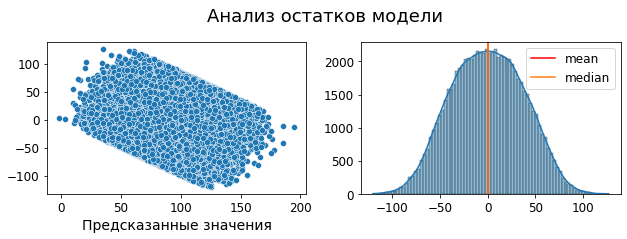


Данные качества модели по региону 1

РАСЧЁТ R2:
Учтённые факторы на 100.0 процентов объясняют целевую


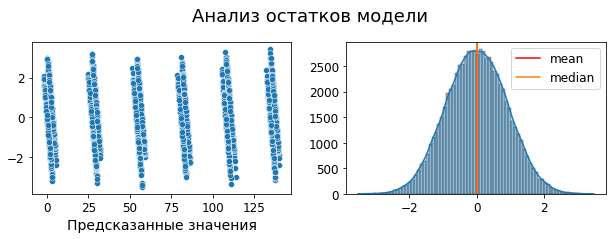


Данные качества модели по региону 2

РАСЧЁТ R2:
Учтённые факторы на 0.0 процентов объясняют целевую


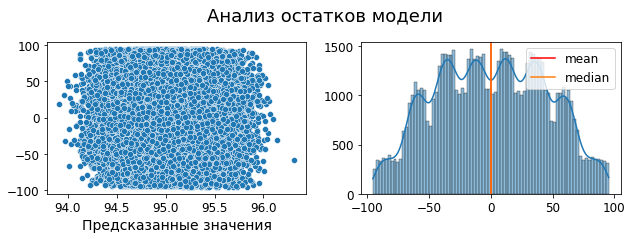

In [22]:
# Анализ качества модели на трейн-выборке

for num, model in enumerate(model_list):
  print('Данные качества модели по региону', num)
  print()
  quality_model(target_train_list[num], model_list[num].predict(features_train_scaled_list[num]))
  print()

Высокие значение R2 для 1 региона объясняются тем что в этом регионе была выялвялена сильная зависимость целевого фаткора от параметра f2. На гистограме ошибок (правый график): среднее и медиана совпадают, но распределение для регионов 1, 2 не нормальное. Также отметим крайне низкое значение R2 для 2 региона.


### Анализ качества модели

Гистограмма предсказанных данных по региону 0



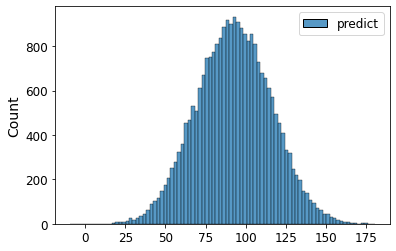

Гистограмма предсказанных данных по региону 1



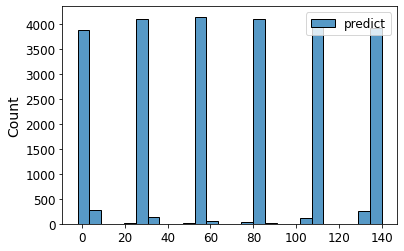

Гистограмма предсказанных данных по региону 2



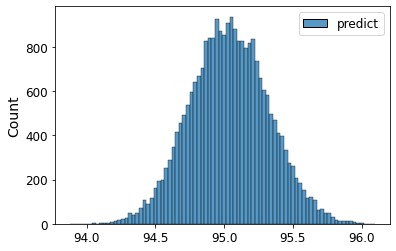

In [23]:
# Графическое представление предсказанных данных

for num, predict in enumerate(prediction_list):
  print('Гистограмма предсказанных данных по региону', num)
  print()
  sns.histplot(data = predict)
  plt.show()

In [24]:
# Выберем в каждом регионе 200 скважин с наибольшими предсказанными запасами
best_list = []
best_list_real = []

for i in range(len(model_list)):
    best_pred = prediction_list[i].sort_values(by='predict', ascending=False).head(200)
    best_list.append(best_pred)
    
for i in range(len(target_test_list)):
    best_real = target_test_list[i].sort_values(ascending=False).head(200)
    best_list_real.append(best_real)

Оценка качества прогноза моделей.

In [25]:
for i in range(len(model_list)):
  print('Модель по региону ' + str(i))
  metrics_model(target_test_list[i], prediction_list[i], best_list_real[i], best_list[i])
  print()

Модель по региону 0
R2   =  0.28
MAPE =  212.25 процентов
MAE  =  30.92
RMSE =  37.58
Запас предсказанного сырья (200 лучших скважин) =  predict    31102.33
dtype: float64
Запас реального сырья (200 лучших скважин) =  36690.99

Модель по региону 1
R2   =  1.0
MAPE =  2.7002889601752964e+16 процентов
MAE  =  0.72
RMSE =  0.89
Запас предсказанного сырья (200 лучших скважин) =  predict    27746.03
dtype: float64
Запас реального сырья (200 лучших скважин) =  27589.08

Модель по региону 2
R2   =  0.0
MAPE =  1709593019246979.8 процентов
MAE  =  37.92
RMSE =  44.9
Запас предсказанного сырья (200 лучших скважин) =  predict    19161.68
dtype: float64
Запас реального сырья (200 лучших скважин) =  37650.36



Выведем на экран значения коэффициентов модели по регионам

In [26]:
for i in range(len(model_list)):
  name = 'Коэффициенты модели по региону '+ str(i)
  coeff_df = pd.DataFrame(model_list[i].coef_.flatten(), features_test_scaled_list[i].columns, columns=[name]) 
  display(coeff_df.sort_values(by = name, ascending=False))

,Коэффициенты модели по региону 0
f2,21.425564
f0,3.132274
f1,-7.108177


,Коэффициенты модели по региону 1
f2,45.886033
f1,-0.112935
f0,-1.299483


,Коэффициенты модели по региону 2
f1,0.229669
f0,0.089345
f2,-0.118828


**Вывод: В данном пукте нами были обучены три модели (для каждого региона своя так, как данные по регионам очень отличаются между собой).
Предсказанные данные для региона 1 распределяются не нормально (имеют вид дискретных значений), данные по регионам 0, 2 близки к нормальному распредлению. Как и ожидалось больший вес при предсказывании модели имеет параметр f2. Модель для 2 региона получилась крайне не точная.**

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья в регионе для безубыточной разработки новых скважин.


In [27]:
# Расчитаем минимальные запасы нефти в регионе, которые окупят бюджет на разработку скважин в районе

BUDGET = 10_000_000_000 # бюджет на разработку скважин в регионе
DOVOD = 450_000 # доход с каждой единицы продукта

min_product_region = BUDGET / DOVOD
print('Минимальные запасы сырья в регионе:', round(min_product_region))

min_product = min_product_region / 200
print('Минимальные запасы сырья на скважину:', round(min_product))

Минимальные запасы сырья в регионе: 22222
Минимальные запасы сырья на скважину: 111


Минимальный запас сырья для того, чтобы добыча окупилась равен 22222 тыс. единиц. Как видно из средних предсказанных запасов сырья все регионы подходят, но самые большие средние запасы располагаюстя во 2 регионе.

**Вывод: Регионы 0,1 подходят для безубыточной разработки новых скважин по предсказанным запасам. Предсказаныне запасы региона 2 меньше требуемых запасов, но фактические запасы в этом регоине превышают требуемые (сказывается низкая точность модели для этого региона). Поэтому проведем расчет прибыли и рисков для всех трех регионов, использую технику Bootstrap.**

## Расчёт прибыли и рисков 

По условиям поставленной задачи выберем 200 наиболее прибыльных скважин в кадом из регионов. Предсказанные данные храняться в prediction_list, реальные данные - в target_test_list.

In [28]:
# Соединим в одном датафрейме данные по предсказанным запасам, реальным и id скважин
product_data_list = []
for i in range(len(prediction_list)):
  prediction = pd.DataFrame(prediction_list[i], index=target_test_list[i].index, columns=['predict'])
  product_data = pd.concat([prediction, target_test_list[i], data[i]['id']], axis= 1, join='inner')
  product_data.rename(columns = {'product':'real'}, inplace = True)
  product_data_list.append(product_data)

In [29]:
# Выберем в каждом регионе 200 скважин с наибольшими предсказанными запасами
best_list = []
for i in range(len(product_data_list)):
  best = product_data_list[i].sort_values(by='predict', ascending=False).head(200)
  best_list.append(best)

In [30]:
# Посчитаем суммарную прибыль для полученного сырья на 200 лучших скважинах
profit_predicted = []
profit_real = []

for i in range(len(best_list)):
  profit_predicted.append(round(best_list[i]['predict'].sum() * DOVOD))
  profit_real.append(round(best_list[i]['real'].sum() * DOVOD))

In [31]:
# Выводим полученные результаты на экран
for i in range(len(profit_predicted)):
    print('Суммарная прогнозная выручка c 200 лучших скважинах по региону ' + str(i) + ' равна: ', profit_predicted[i])
    print('Суммарная реальная выручка c 200 лучших скважинах по региону ' + str(i) + ' равна: ', profit_real[i])
    print('Разница: ', profit_real[i] - profit_predicted[i])
    print('Прогнозная прибыль c 200 лучших скважинах по региону ' + str(i) + ' равна: ', profit_predicted[i] - BUDGET)
    print('Реальная прибыль c 200 лучших скважинах по региону ' + str(i) + ' равна: ', profit_real[i]- BUDGET)

    print()

Суммарная прогнозная выручка c 200 лучших скважинах по региону 0 равна:  13996048877
Суммарная реальная выручка c 200 лучших скважинах по региону 0 равна:  13320826043
Разница:  -675222834
Прогнозная прибыль c 200 лучших скважинах по региону 0 равна:  3996048877
Реальная прибыль c 200 лучших скважинах по региону 0 равна:  3320826043

Суммарная прогнозная выручка c 200 лучших скважинах по региону 1 равна:  12485712052
Суммарная реальная выручка c 200 лучших скважинах по региону 1 равна:  12415086697
Разница:  -70625355
Прогнозная прибыль c 200 лучших скважинах по региону 1 равна:  2485712052
Реальная прибыль c 200 лучших скважинах по региону 1 равна:  2415086697

Суммарная прогнозная выручка c 200 лучших скважинах по региону 2 равна:  8622757627
Суммарная реальная выручка c 200 лучших скважинах по региону 2 равна:  8515754401
Разница:  -107003226
Прогнозная прибыль c 200 лучших скважинах по региону 2 равна:  -1377242373
Реальная прибыль c 200 лучших скважинах по региону 2 равна:  -14842

Как видим, 2 добыча во 2 регионе по 200 лучшим предсказанным скважинам принесет только убытки. Наибольший доход получается при добыче в 0 регионе. Но для этого региона наша модель имела меньшую точность, а значит большую неточность и риски чем для 1 региона. Прорим регионы используяю технику Bootstrap.

In [33]:
# Соединим в одном датафрейме данные по предсказанным значениям и реальным
data_for_bootstrap_regions = []

for i in range(len(model_list)):
    data_for_bootstrap = pd.concat([data[i], prediction_list[i]], axis= 1, join='inner')
    data_for_bootstrap_regions.append(data_for_bootstrap)

In [34]:
# Применяем технику bootstrap для того, чтобы 1000 раз выбрать 200 лучших скважин из 500 случайных и найти по ним выручку
revenue_regions = []
lower_regions = []
upper_regions = []
risk_regions = []

for i in range(len(data_for_bootstrap_regions)):
    
    revenue_bootstrap = []
    for j in range(1000):
        subsample = data_for_bootstrap_regions[i].sample(n=500, replace=True, random_state=RANDOM_STATE + j)
        best_predicted = subsample.sort_values(by='predict', ascending=False).head(200)

        revenue = round(best_predicted['product'].sum() * DOVOD)
        revenue_bootstrap.append(revenue)

    revenue_bootstrap_pd = pd.DataFrame(revenue_bootstrap, columns=['revenue'])
    revenue_regions.append(round(mean(revenue_bootstrap)))
    lower_regions.append(round(revenue_bootstrap_pd.quantile(0.025)['revenue']))
    upper_regions.append(round(revenue_bootstrap_pd.quantile(0.975)['revenue']))

    risk = round((revenue_bootstrap_pd['revenue'] <= BUDGET).sum() * 0.1, 2)
    risk_regions.append(risk)

In [35]:
# Выводим полученные результаты на экран

for i in range(len(revenue_regions)):
    profit = revenue_regions[i] - BUDGET
    upper = upper_regions[i] - BUDGET
    lower = lower_regions[i] - BUDGET
    risk = risk_regions[i]

    print('Суммарная прибыль c 200 лучших скважинах по региону ' + str(i) + ' равна: ', profit)
    print('Верхняя граница интревала прибыли: ', upper)
    print('Нижняя граница интревала прибыли: ', lower)
    print('Процент убыточных скважин: ', risk)
    print()

Суммарная прибыль c 200 лучших скважинах по региону 0 равна:  388797149
Верхняя граница интревала прибыли:  860419218
Нижняя граница интревала прибыли:  -150899289
Процент убыточных скважин:  6.7

Суммарная прибыль c 200 лучших скважинах по региону 1 равна:  457004227
Верхняя граница интревала прибыли:  860873031
Нижняя граница интревала прибыли:  57108127
Процент убыточных скважин:  1.6

Суммарная прибыль c 200 лучших скважинах по региону 2 равна:  -1387742015
Верхняя граница интревала прибыли:  -859557356
Нижняя граница интревала прибыли:  -1964552608
Процент убыточных скважин:  100.0



**Вывод: Регион 2 не подходит для коммерчески успешной добычи так, как затраты на бурение в этом регионе превышают доходы. Для региона 1 модель предсказывает более точные значение запасов чем для региона 0 (так как у модели для региона 1 метрика R2 выше чем у модели для региона 0). Поэтому доход прогнозируемый с веротяностью 97.5% для 1 региона выше чем для 0. Для разработки скважин предлагается регион 1.**

---



## Общий вывод

В рамках данного исследования были загружены и изучены данные о характеристиках скважин. Были исследованы зависимости между данными: объём запасов в скважине для 1 региона сильно зависит от параметра f2.  

Были обучены три модели (для каждого региона). По условию задачи для исследования использовалась модель линейной регрессии. Модели были обучены на тренировочной выборке. Самая точная получилась модель для 1 региона (R2 = 1). Модель для 2 региона получилась крайне не точная.

Для выбора региона для добычи был произведен рассчет прибылей и рисков. Техникой Bootstrap были выбраны 1000 выборок, чтобы найти распределение прибыли. Были посчитаны средние значения прибылей. Регион 2 не подходит для коммерчески успешной добычи так, как затраты на бурение в этом регионе превышают доходы. Для регионов были посчитаны 95% доверительные интервалы и риски получить отрицательную доходность. У 1 региона ниже риски получить убыток (1.6%), чем у региона 0 (6.7%). Также для 0 региона нижняя граница доверительного интревала прибыли имеет отрицательное значение, риски в этом регионе намного выше чем в 1. Исходя из значений дохода и риска как более преспективный для добычи был выбран регион 1. 